In [2]:
#make necesarry imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import sys, os
from contextlib import contextmanager
import matplotlib as mpl
import seaborn as sns
import sklearn

# Forecasting

In [3]:
df = pd.read_csv('forecasting_data.csv')
df.head()

,Period,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118


## 1. Visualize and interprete the pattern of this time-series

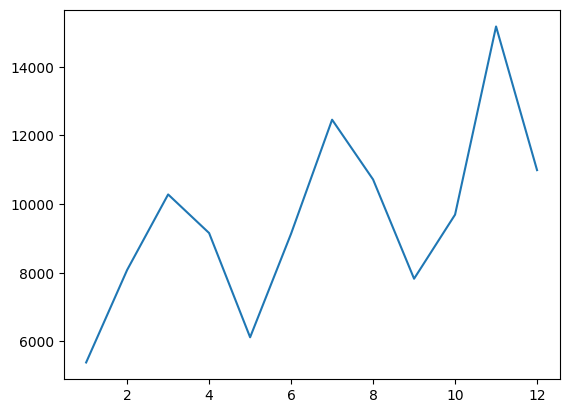

In [4]:
plt.plot(df['Period'], df['Sales'])
plt.show()

## 2. Predict future demand in the four next quarters without seasonality

### Using moving average

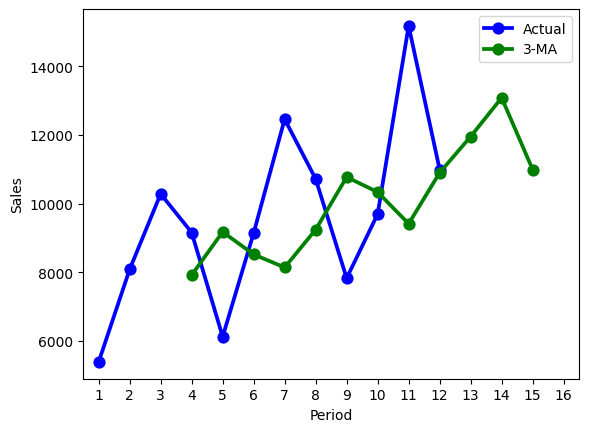

In [11]:
# Using moving average
def moving_average(df, k, to_period):
    moving_average_df = pd.DataFrame(columns=['Period','Sales'])
    for m in range(0, to_period):
        m = int(m)
        if m < k:
            prediction = float("nan")
        else:
            history = df["Sales"][m-k:m]
            prediction = history.mean()
        moving_average_df.loc[m] = [m+1, prediction]
    return moving_average_df
    

f, ax = plt.subplots(1, 1)
ma_df = moving_average(df, 3, 16)
ma_df['Period'] = ma_df['Period'].astype(int)
sns.pointplot(x='Period', y='Sales', data=df, color='b')
sns.pointplot(x='Period', y='Sales', data=ma_df, color='g')
ax.legend(handles=ax.lines[::len(df)+1], labels=["Actual", "3-MA"])
plt.show()

### Using exponential smoothing

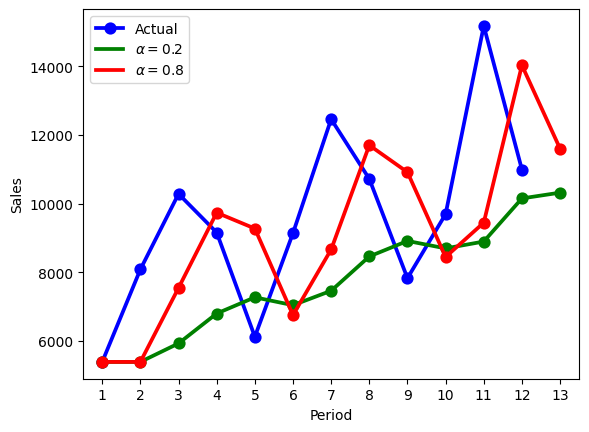

In [14]:
def exponential_smoothing(df, alpha):
    es_df = pd.DataFrame(columns=['Period','Sales'])
    es_df.loc[0] = [1, df["Sales"][0]]
    num_df = len(df)
    for m in range(0, num_df):
        prediction = alpha * df["Sales"][m] + (1-alpha) * es_df["Sales"][m]
        es_df.loc[m+1] = [m+2, prediction]
    return es_df

f, ax = plt.subplots(1, 1)
es_df_02 = exponential_smoothing(df, 0.2)
es_df_08 = exponential_smoothing(df, 0.8)
es_df_02['Period'] = es_df_02['Period'].astype(int)
es_df_08['Period'] = es_df_08['Period'].astype(int)
sns.pointplot(ax=ax, x='Period', y='Sales', data=df, color='b')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_02, color='g')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='r')

# Legend
ax.legend(handles=ax.lines[::len(df)+2], labels=["Actual", r'$\alpha=0.2$', r"$\alpha=0.8$"])
plt.show()

## 3. Predict future demand in the four next quarters with seasonality

C:\Users\TP\AppData\Local\Temp\ipykernel_31600\1547533834.py:31: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(season, avg_arr, 3)


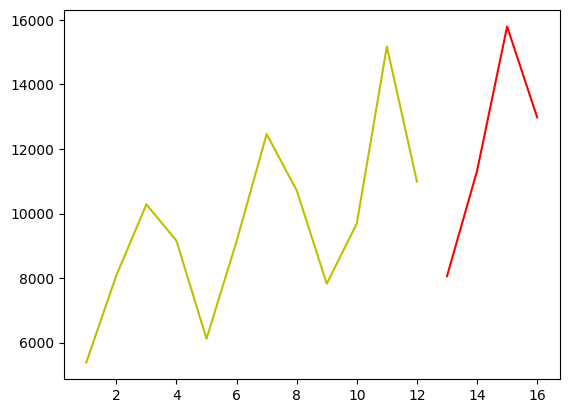

In [22]:
#season function
def get_season(row):
    if row['Period'] >= 5 and row['Period'] <= 8:
        return 'II'
    elif row['Period'] >= 9 and row['Period'] <= 12:
        return 'III'
    else:
        return 'I'
def get_seq(row):
    return row['Period']%4 and row['Period']%4 or 4

def predict_with_seasonality(df, months):
    new_df = df.copy()
    new_df['Season'] = new_df.apply(get_season, axis=1)
    new_df['Seq'] = new_df.apply(get_seq, axis=1)

    season_df = pd.DataFrame((new_df.pivot(index='Seq', columns='Season', values='Sales')).to_records())
    season_df.index = season_df['Seq']
    season_df = season_df.drop(['Seq'], axis=1)
    
    avg_df = season_df.mean()
    
    seasonal_index_df = pd.DataFrame(columns=['I','II','III'])
    seasonal_index_df['I'] = season_df['I'] / avg_df['I']
    seasonal_index_df['II'] = season_df['II'] / avg_df['II']
    seasonal_index_df['III'] = season_df['III'] / avg_df['III']
    seasonal_index_df['Avg'] = (seasonal_index_df['I'] + seasonal_index_df['II'] + seasonal_index_df['III']) / 3
    
    season = np.array([1,2,3])
    avg_arr = np.array([avg_df['I'], avg_df['II'], avg_df['III']])
    fit = np.polyfit(season, avg_arr, 3)
    poly = np.poly1d(fit)
    average_predict = poly(4)
    
    forecast_df = pd.DataFrame(columns=['Period','Sales'])
    forecast_df['Period'] = months
    forecast_df['Sales'] = seasonal_index_df['Avg'].values * average_predict
    forecast_df.index = np.array(months) - 1
    return forecast_df

season_df = predict_with_seasonality(df, [13,14,15,16])

f, ax = plt.subplots(1, 1)
plt.plot(df['Period'], df['Sales'], c='y')
plt.plot(season_df['Period'], season_df['Sales'], c='r')
plt.show()

# 4.Evaluation: compare the above implemented methods

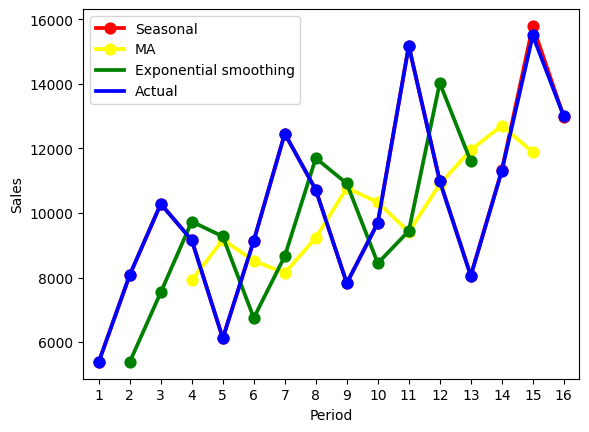

In [23]:
eval_df = pd.read_csv('forecasting_actual.csv')
eval_df = pd.concat([df, eval_df], ignore_index=True)

f, ax = plt.subplots(1, 1)
sns.pointplot(ax=ax, x='Period', y='Sales', data=pd.concat([df, season_df], ignore_index=True), color='r')
sns.pointplot(ax=ax, x='Period', y='Sales', data=ma_df, color='yellow')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='green')
sns.pointplot(ax=ax, x='Period', y='Sales', data=eval_df, color='b')
ax.legend(handles=ax.lines[::len(df)+5], labels=["Seasonal", 'MA', "Exponential smoothing", "Actual"])
plt.show()

In [24]:
MAD_3MA = np.mean(np.abs(eval_df['Sales'] - ma_df['Sales']))
print("MAD of {0}: {1}".format("3-MA", MAD_3MA))
MAD_ES_02 = np.mean(np.abs(eval_df['Sales'] - es_df_02['Sales']))
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.2", MAD_ES_02))
MAD_ES_08 = np.mean(np.abs(eval_df['Sales'] - es_df_08['Sales']))
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.8", MAD_ES_08))
MAD_seasonal = np.mean(np.abs(eval_df['Sales'] - season_df['Sales']))
print("MAD of {0}: {1}".format("Seasonality Method", MAD_seasonal))

MAD of 3-MA: 2423.9783950617284
MAD of Exponential smoothing with alpha=0.2: 1942.5085752797859
MAD of Exponential smoothing with alpha=0.8: 490.90977153365293
MAD of Seasonality Method: 85.88221407246601


In [25]:
MSE_3MA = np.mean((eval_df['Sales'] - ma_df['Sales'])**2)
print("MSE of {0}: {1}".format("3-MA", MSE_3MA))
MSE_ES_02 = np.mean((eval_df['Sales'] - es_df_02['Sales'])**2)
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.2", MSE_ES_02))
MSE_ES_08 = np.mean((eval_df['Sales'] - es_df_08['Sales'])**2)
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.8", MSE_ES_08))
MSE_seasonal = np.mean((eval_df['Sales'] - season_df['Sales'])**2)
print("MSE of {0}: {1}".format("Seasonality Method", MSE_seasonal))

MSE of 3-MA: 8730126.716163695
MSE of Exponential smoothing with alpha=0.2: 5870893.334855315
MSE of Exponential smoothing with alpha=0.8: 331335.4158811055
MSE of Seasonality Method: 22206.089646320368
